# Demonstration for RED-diff

Paper  https://arxiv.org/abs/2305.04391.

Solving a (nonlinear) inverse problem: 
$$
y=f(x_{0})+v,\quad v\sim{\mathcal{N}}(0,\sigma_{v}^{2}I)
$$


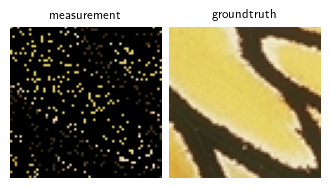

In [10]:
import numpy as np
import torch

import deepinv as dinv
from deepinv.utils.plotting import plot
from deepinv.optim.data_fidelity import L2
from deepinv.utils.demo import load_url_image, get_image_url
from tqdm import tqdm  # to visualize progress

# device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
device = "mps" # running on Apple Silicon

url = get_image_url("butterfly.png")

x_true = load_url_image(url=url, img_size=64).to(device)
x = x_true.clone()

sigma = 12.75 / 255.0  # noise level

physics = dinv.physics.Inpainting(
    tensor_size=(3, x.shape[-2], x.shape[-1]),
    mask=0.1,
    pixelwise=True,
    device=device,
)

y = physics(x_true)

imgs = [y, x_true]
plot(
    imgs,
    titles=["measurement", "groundtruth"],
)

The forward diffusion process is:
$$
d x=-{\frac{\beta(t)}{2}}x d t+{\sqrt{\beta(t)}}d w,
$$

with reverse SDE:
$$
d x=\left[-\frac{\beta(t)}{2}x-\beta(t)\nabla_{x_{t}}\log p_{t}(x_{t})\right]d t+\sqrt{\beta(t)}d\bar{w},
$$

The prior is $p(x)$ and we aim to sample from the posterior $p(x|y)$ by modifying the score in the reverse SDE:  

$$
d x=\left[-\frac{\beta(t)}{2}x-\beta(t)(\nabla_{x_{t}}\log p_{t}(x_{t})+\nabla_{x_{t}}\log p_{t}(y|x_{t}))\right]d t+\sqrt{\beta(t)}d\bar{w},
$$

The main difficulty is to get a tractable form of $p(y \mid x_t)$. 